In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers, callbacks


In [2]:
train_dir = "/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training/"


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    batch_size=64,
    image_size=(100, 100),
    seed=123,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, 
    validation_split=0.2,
    subset='validation',
    batch_size=64,
    image_size=(100, 100),
    seed=42
)

Found 104456 files belonging to 207 classes.
Using 83565 files for training.


I0000 00:00:1754937522.488421     990 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 104456 files belonging to 207 classes.
Using 20891 files for validation.


In [3]:
test_dir  = "/kaggle/input/fruits/fruits-360_100x100/fruits-360/Test/"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size=64,
    image_size =(100, 100),
    seed=45
)

Found 34864 files belonging to 207 classes.


In [4]:
class_names = sorted(os.listdir(train_dir))

print("Class Names:", class_names)
num_classes = len(class_names)
print("Number of Classes:", num_classes)

Class Names: ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6', 'Apple 7', 'Apple 8', 'Apple 9', 'Apple Braeburn 1', 'Apple Core 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple Rotten 1', 'Apple hit 1', 'Apple worm 1', 'Apricot 1', 'Avocado 1', 'Avocado Black 1', 'Avocado Green 1', 'Avocado ripe 1', 'Banana 1', 'Banana 3', 'Banana 4', 'Banana Lady Finger 1', 'Banana Red 1', 'Beans 1', 'Beetroot 1', 'Blackberrie 1', 'Blackberrie 2', 'Blackberrie half rippen 1', 'Blackberrie not rippen 1', 'Blueberry 1', 'Cabbage red 1', 'Cabbage white 1', 'Cactus fruit 1', 'Cactus fruit green 1', 'Cactus fruit red 1', 'Caju seed 1', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula 1', 'Carrot 1', 'Cauliflower 1', 'Cherimoya 1', 'Cherry 1', 'Cherr

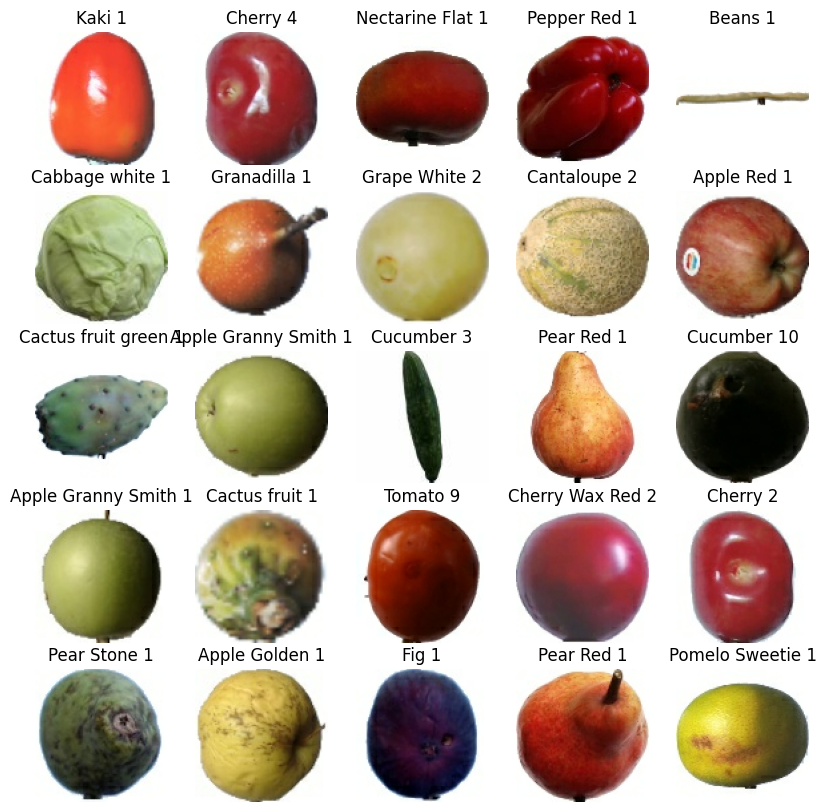

In [5]:
def show_images(dataset, calass_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):

        for i in range(25):
            ax = plt.subplot(5, 5, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis('off')

show_images(train_ds, class_names)
plt.show()

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_da = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augm = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
], name="data_augmentation")

# **CNN Model**

In [8]:
# CNN model
from tensorflow.keras import models
normalization_layer = layers.Rescaling(1./255)
cnn_model = models.Sequential([
    layers.Input(shape=(100, 100, 3)), 
    normalization_layer,
    layers.Conv2D(filters=8, kernel_size=(3,3), padding='Same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(filters=16, kernel_size=(3,3), padding='Same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=(2,2)),
    layers.Dropout(0.3),
    layers.Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=(2,2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')

    
])
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [9]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 207)            │       106,191 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,472,031 (9.43 MB)

 Trainable params: 2,472,031 (9.43 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stopping = callbacks.EarlyStopping(patience=5)

history = cnn_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/10


I0000 00:00:1754937545.938698    1045 service.cc:148] XLA service 0x7ad2c000d920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754937545.938757    1045 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754937546.217257    1045 cuda_dnn.cc:529] Loaded cuDNN version 90300


  13/1306 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.0071 - loss: 5.6053  

I0000 00:00:1754937549.944970    1045 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1306/1306 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.3006 - loss: 3.1381 - val_accuracy: 0.9505 - val_loss: 0.2448
Epoch 2/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8590 - loss: 0.4219 - val_accuracy: 0.9841 - val_loss: 0.0753
Epoch 3/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9118 - loss: 0.2557 - val_accuracy: 0.9893 - val_loss: 0.0511
Epoch 4/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9361 - loss: 0.1852 - val_accuracy: 0.9893 - val_loss: 0.0439
Epoch 5/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9473 - loss: 0.1509 - val_accuracy: 0.9921 - val_loss: 0.0290
Epoch 6/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9548 - loss: 0.1277 - val_accuracy: 0.9933 - val_loss: 0.0245
Epoch 7/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9582 - loss: 0.1177 - val_accuracy: 0.9908 - val_loss: 0.0286
Epoch 8/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9644 - loss: 0.10

In [11]:
#test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
test_loss, test_acc = cnn_model.evaluate(test_ds)
print(f'Test Accuracy:{test_acc:.2f}')

545/545 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9431 - loss: 0.2030
Test Accuracy:0.94


# **ResNet Model**

In [12]:
base_model = tf.keras.applications.ResNet50(include_top=False,
                                           weights='imagenet', input_shape=(100, 100, 3))

In [13]:
preprocess_input = tf.keras.applications.resnet.preprocess_input
base_model.trainable = False

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

In [15]:
inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augm(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

resnet_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

resnet_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [17]:
early_stopping = callbacks.EarlyStopping(patience=3)

history = resnet_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 89s 58ms/step - accuracy: 0.3897 - loss: 3.0707 - val_accuracy: 0.9319 - val_loss: 0.4736
Epoch 2/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 71s 54ms/step - accuracy: 0.9039 - loss: 0.4540 - val_accuracy: 0.9710 - val_loss: 0.2091
Epoch 3/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 71s 54ms/step - accuracy: 0.9571 - loss: 0.2244 - val_accuracy: 0.9827 - val_loss: 0.1259
Epoch 4/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 70s 54ms/step - accuracy: 0.9741 - loss: 0.1415 - val_accuracy: 0.9891 - val_loss: 0.0840
Epoch 5/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 70s 54ms/step - accuracy: 0.9829 - loss: 0.0979 - val_accuracy: 0.9920 - val_loss: 0.0595
Epoch 6/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 70s 54ms/step - accuracy: 0.9869 - loss: 0.0732 - val_accuracy: 0.9939 - val_loss: 0.0460
Epoch 7/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 71s 54ms/step - accuracy: 0.9902 - loss: 0.0565 - val_accuracy: 0.9951 - val_loss: 0.0359
Epoch 8/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 70s 54ms/step - accuracy: 0.9928 -

In [18]:
test_loss, test_acc = resnet_model.evaluate(test_ds)
print(f"ResNet Test Accuracy:{test_acc:.2f}")

545/545 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.9820 - loss: 0.0763
ResNet Test Accuracy:0.98


In [20]:
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

In [21]:
from sklearn.metrics import confusion_matrix

In [43]:
test_class_names = os.listdir(test_dir)

print("Class Names:", test_class_names)
test_num_classes = len(test_class_names)
print("Number of Classes:",test_num_classes)

Class Names: ['Melon Piel de Sapo 1', 'Dates 1', 'Nectarine Flat 2', 'Apple Crimson Snow 1', 'Onion Red 1', 'Cherry Wax Yellow 1', 'Cherry 3', 'Avocado Green 1', 'Pear Red 1', 'Potato Red 1', 'Apple 7', 'Quince 4', 'Tomato Cherry Red 2', 'Apple Red 3', 'Huckleberry 1', 'Avocado 1', 'Blackberrie 1', 'Grape White 2', 'Tomato not Ripen 1', 'Tomato 9', 'Nut Pecan 1', 'Guava 1', 'Walnut 1', 'Apple 18', 'Tomato Maroon 1', 'Cherry Wax Red 1', 'Cucumber 1', 'Rambutan 1', 'Cactus fruit red 1', 'Cherry Rainier 2', 'Tomato Cherry Red 1', 'Cherry Sour 1', 'Nut 5', 'Pear 3', 'Pear 1', 'Strawberry 1', 'Potato Red Washed 1', 'Pear Monster 1', 'Apple worm 1', 'Cherry 4', 'Tomato Cherry Orange 1', 'Potato Sweet 1', 'Apple 5', 'Ginger Root 1', 'Cherry Rainier 3', 'Onion Red Peeled 1', 'Cucumber 5', 'Apple 17', 'Tomato 1', 'Pear Forelle 1', 'Cherry 2', 'Apple 13', 'Apple Red 2', 'Kohlrabi 1', 'Raspberry 1', 'Cherry 5', 'Pepper Yellow 1', 'Mulberry 1', 'Apple 12', 'Cactus fruit 1', 'Apple 19', 'Eggplant l

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


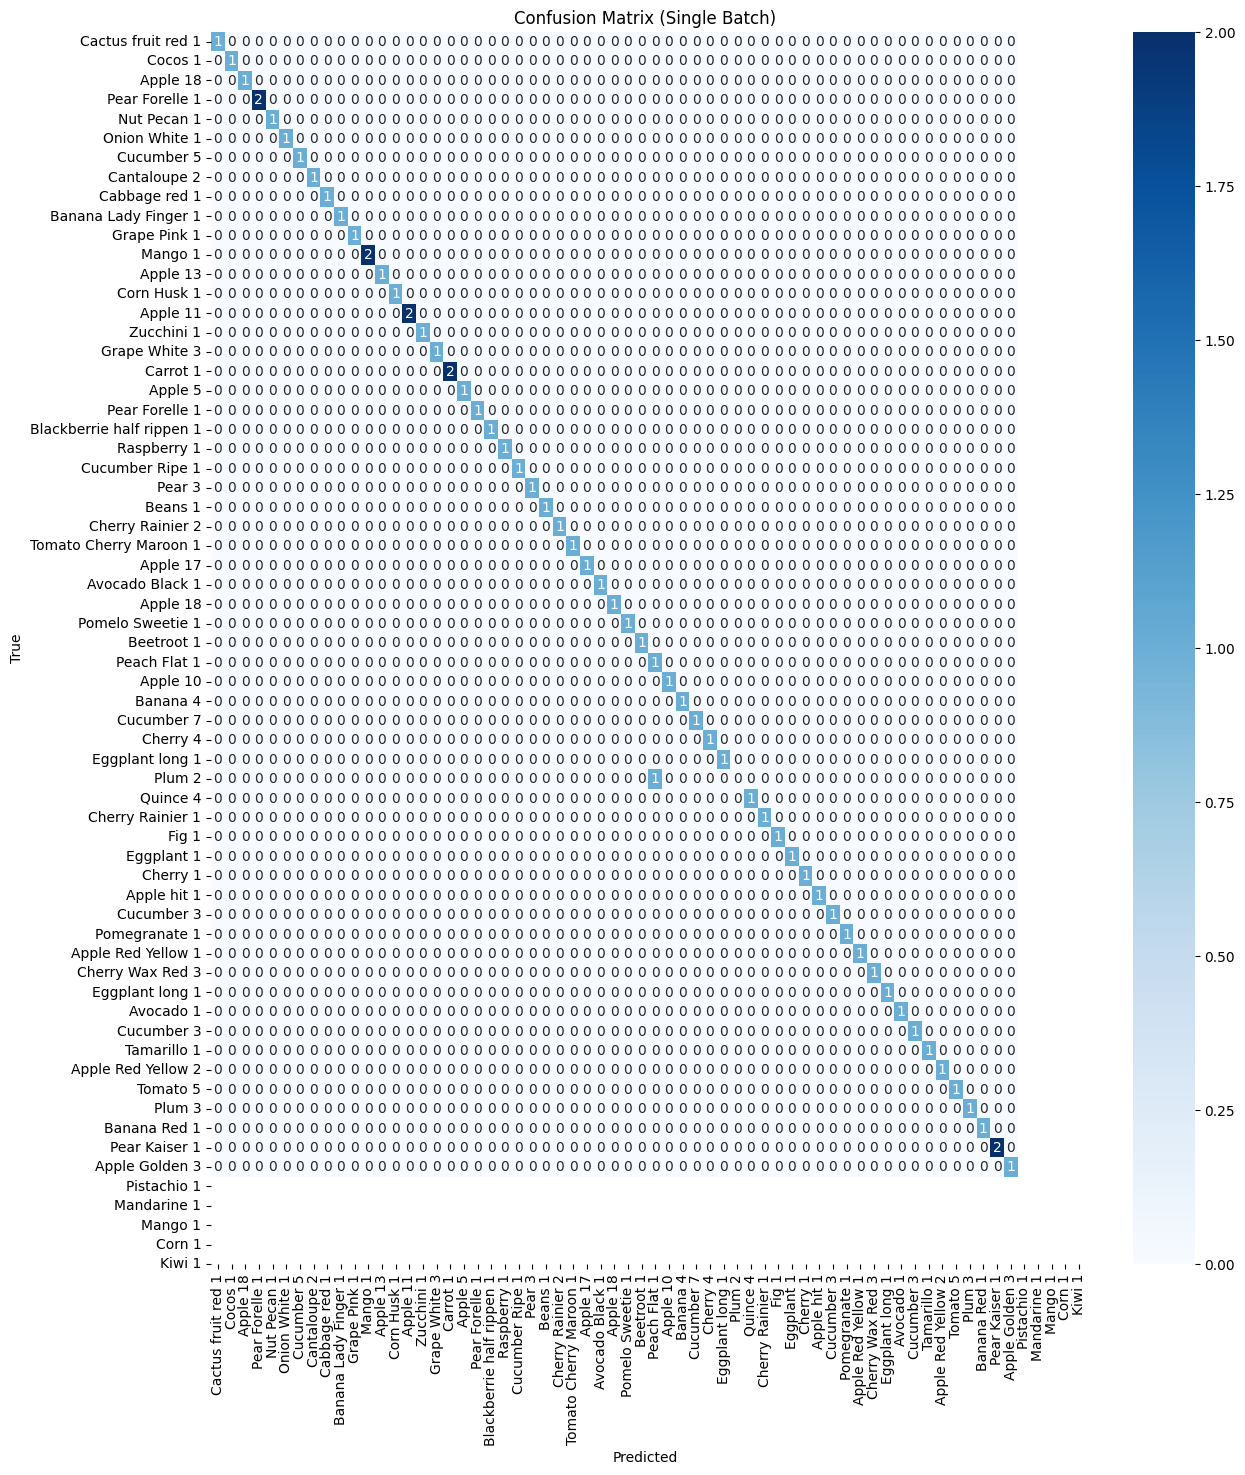

In [50]:
# Get one batch from dataset
images_batch, labels_batch = next(iter(test_ds))

names = []
for i in labels_batch:
    names.append(test_class_names[i])

# Make predictions
y_pred = resnet_model.predict(images_batch)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
conf_mat = confusion_matrix(labels_batch, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(14, 16))
sns.heatmap(conf_mat, annot=True, fmt=".0f", cmap="Blues",
           xticklabels=names, yticklabels=names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Single Batch)")
plt.show()

# **Yolo Model**

In [3]:
!pip install torch==2.2.2+cu118 torchvision==0.17.2+cu118 torchaudio==2.2.2 --extra-index-url https://download.pytorch.org/whl/cu118

!pip install roboflow

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.2/819.2 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 89.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 80.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 2.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 MB 13.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 10.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 103.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 82.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import torch
torch.cuda.is_available()

True

In [5]:
#

from roboflow import Roboflow
rf = Roboflow(api_key="7k9MY7roO7ELVyHdYh7L")
project = rf.workspace("detectionfortrianing").project("fruitdetection-x6tde")
version = project.version(2)
dataset = version.download("yolov8")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to FruitDetection-2 in yolov8:: 100%|██████████| 422/422 [00:00<00:00, 10199.00it/s]


In [6]:
! pip install ultralytics --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.8 MB/s eta 0:00:0000:01


In [7]:
!yolo task=detect mode=train epochs=10 data=/kaggle/working/FruitDetection-2/data.yaml model=yolov8m.pt patience=10 


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.2.2+cu118 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/FruitDetection-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0

In [10]:
!ls /kaggle/working/runs/detect/train

args.yaml			 confusion_matrix.png	 train_batch1.jpg
BoxF1_curve.png			 labels_correlogram.jpg  train_batch2.jpg
BoxP_curve.png			 labels.jpg		 val_batch0_labels.jpg
BoxPR_curve.png			 results.csv		 val_batch0_pred.jpg
BoxR_curve.png			 results.png		 weights
confusion_matrix_normalized.png  train_batch0.jpg


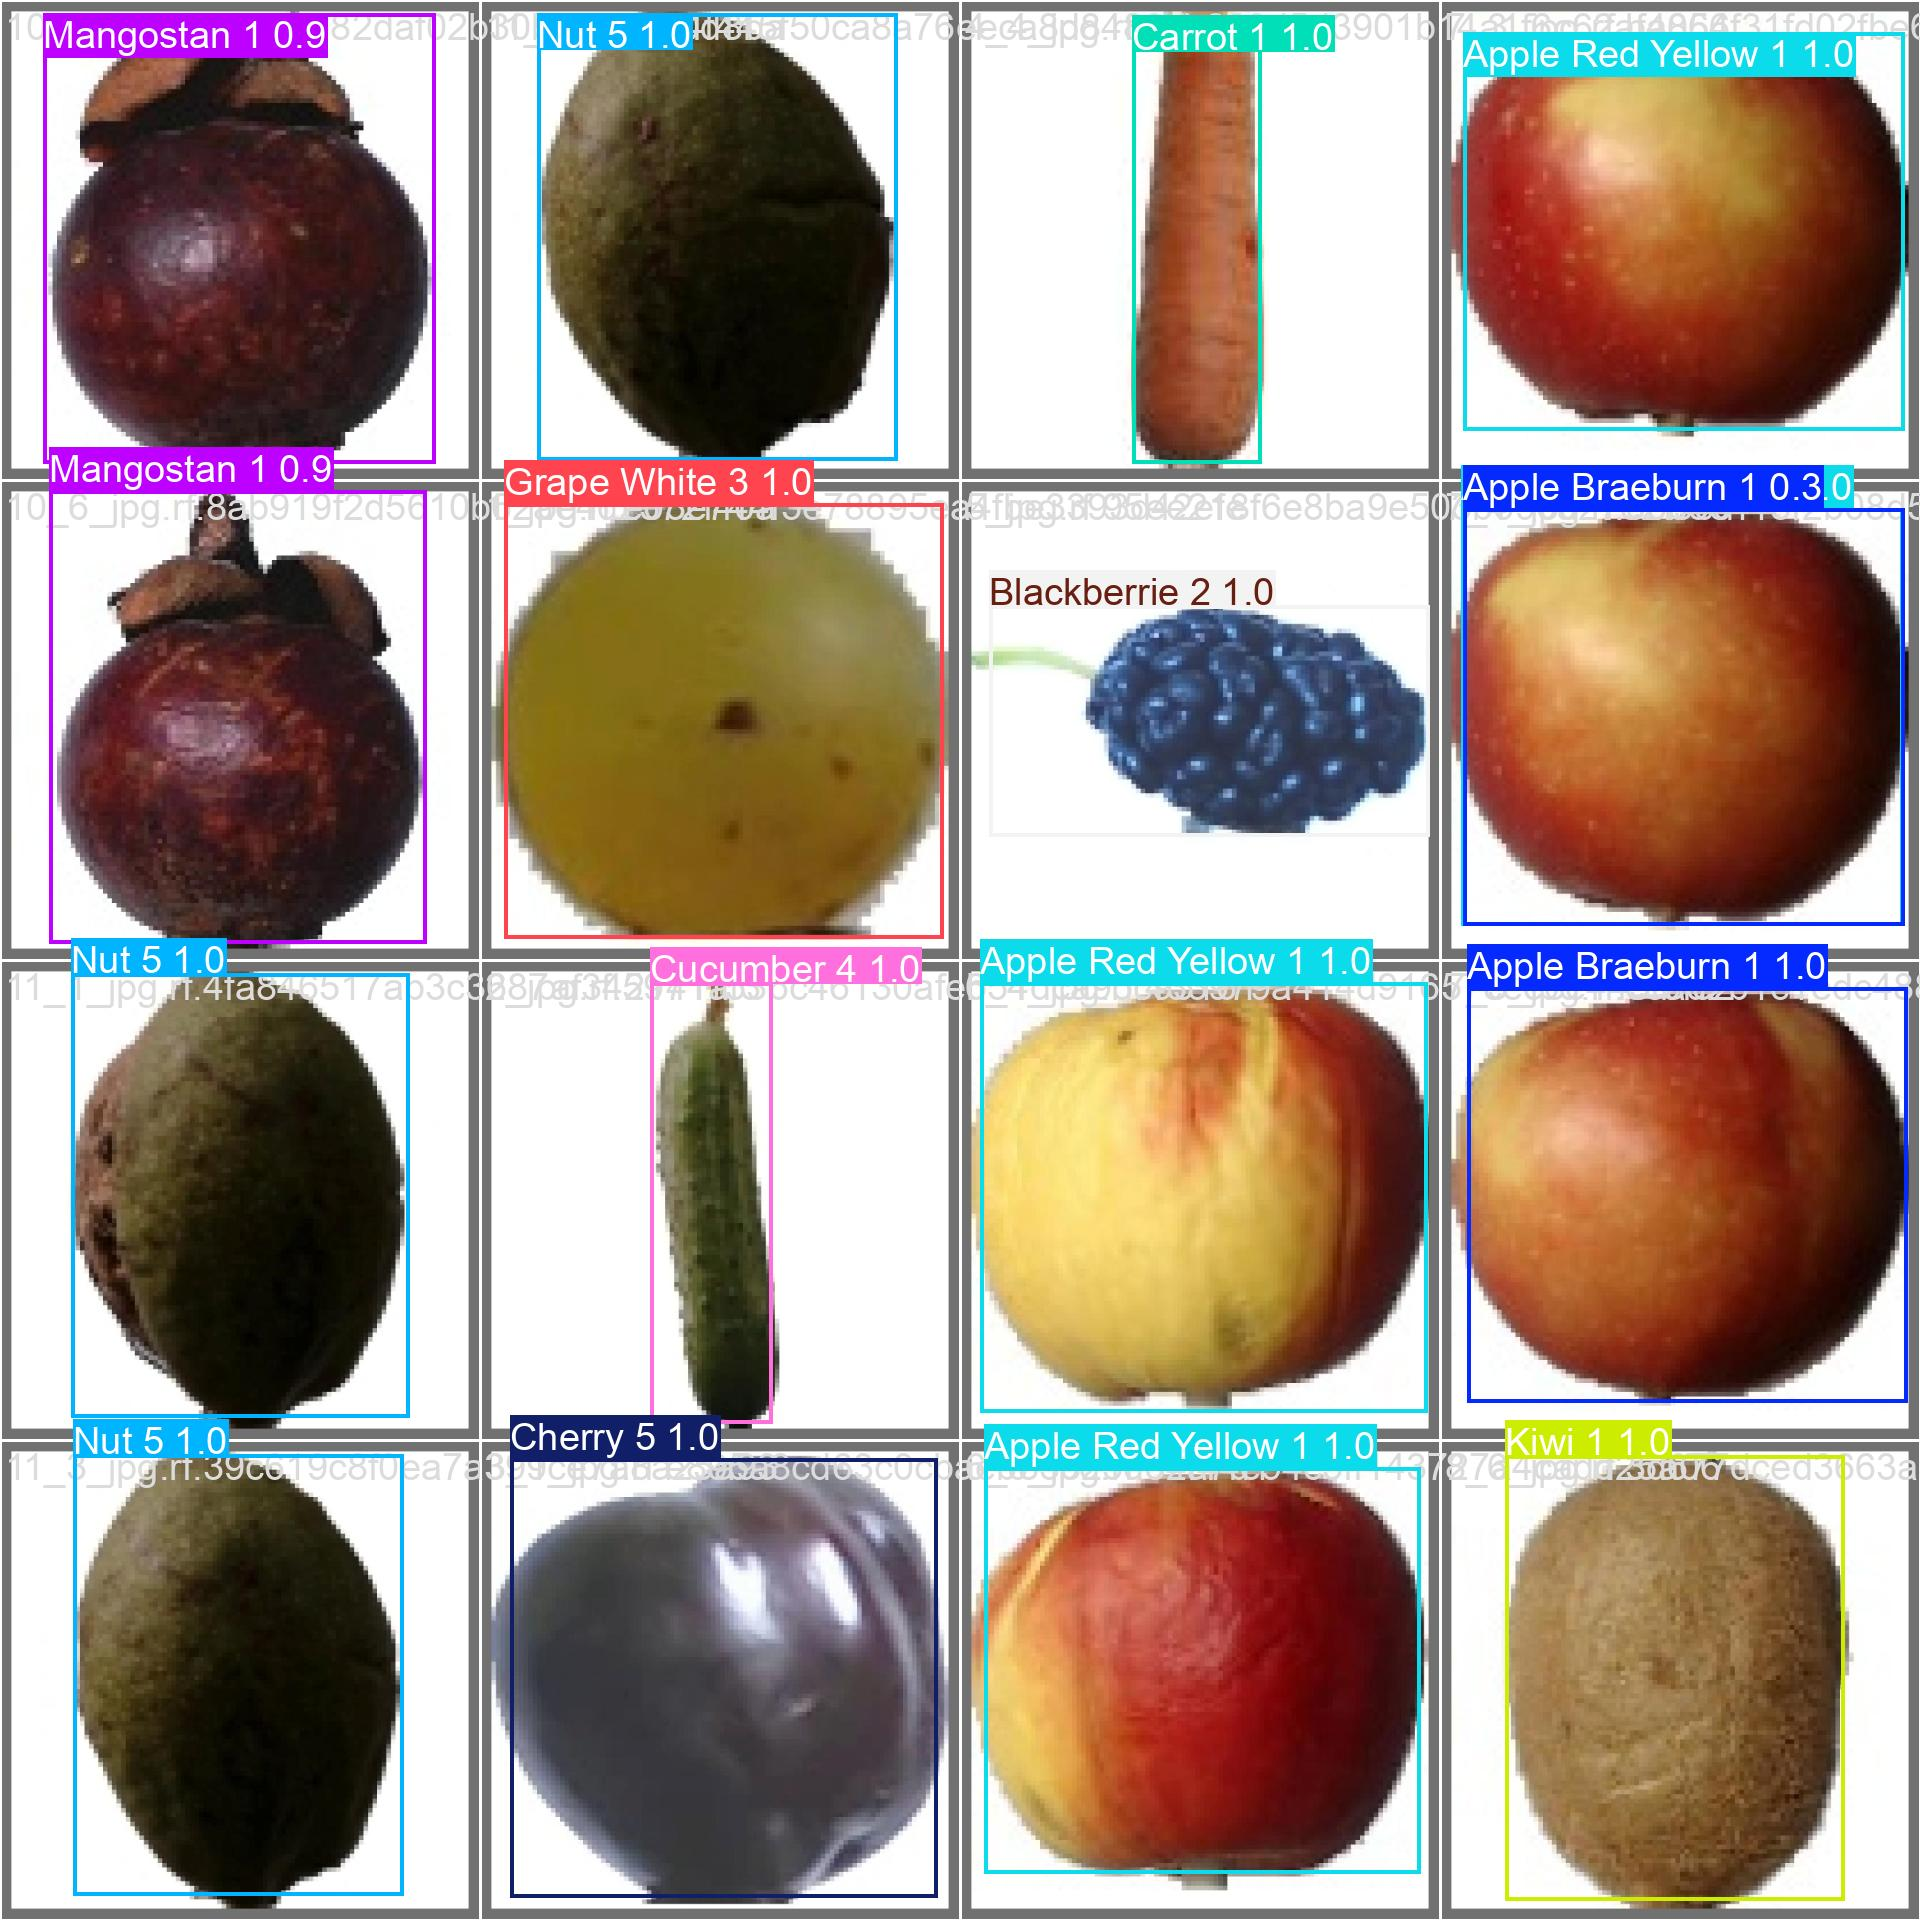

In [11]:
from IPython.display import display, Image

display(Image(filename="/kaggle/working/runs/detect/train/val_batch0_pred.jpg"))

In [ ]:
display(Image(filename="/kaggle/working/runs/detect/train2/val_batch0_labels.jpg"))

In [13]:
!yolo task=detect mode=predict model=/kaggle/working/runs/detect/train/weights/best.pt source=/kaggle/working/FruitDetection-2/valid/images conf=0.5 save=True


Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.2.2+cu118 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,846,129 parameters, 0 gradients, 78.7 GFLOPs

image 1/19 /kaggle/working/FruitDetection-2/valid/images/10_2_jpg.rf.c70a0982daf02b30b0e599d0d8ba3bb8.jpg: 640x640 1 Mangostan 1, 15.3ms
image 2/19 /kaggle/working/FruitDetection-2/valid/images/10_6_jpg.rf.8ab919f2d5610b62ae4d2572f40a414e.jpg: 640x640 1 Mangostan 1, 15.3ms
image 3/19 /kaggle/working/FruitDetection-2/valid/images/11_1_jpg.rf.4fa846517ab3c3687af342141af3814d.jpg: 640x640 1 Nut 5, 15.3ms
image 4/19 /kaggle/working/FruitDetection-2/valid/images/11_3_jpg.rf.39c619c8f0ea7a399ce7a8a25a932453.jpg: 640x640 1 Nut 5, 15.2ms
image 5/19 /kaggle/working/FruitDetection-2/valid/images/11_5_jpg.rf.4f445f50ca8a76eeca8d8483dc204547.jpg: 640x640 1 Nut 5, 15.2ms
image 6/19 /kaggle/working/FruitDetection-2/valid/images/1_jpg.rf.e03e744f5e78895ea4fbe3393d42efe3.jpg: 640x640 1 Grape White 3, 15.2ms
image 7/19 /kaggle/

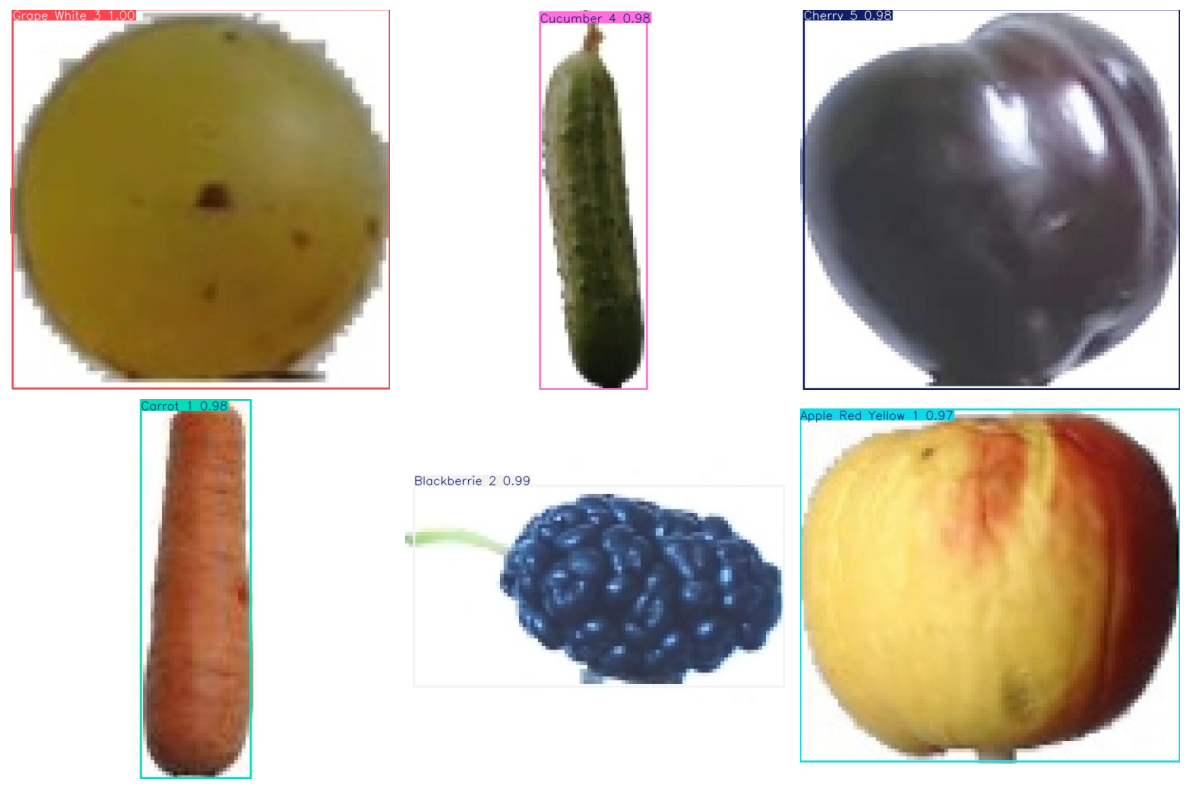

In [63]:
import os
import matplotlib.pyplot as plt
import cv2

# Path to YOLO prediction folder
pred_path = '/kaggle/working/runs/detect/predict'  # adjust if needed

# Get all image files in the folder
images = [f for f in sorted(os.listdir(pred_path)) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
#labels = [l for l in os.listdir()]

# Display up to 6 images
plt.figure(figsize=(12, 8))
for i, img_file in enumerate(images[5:11]):  
    img = cv2.imread(os.path.join(pred_path, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR → RGB
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

# **GAN Model**

In [99]:
import torch 
import random
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import torch.nn as nn
import torch.optim as optim 
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from torchmetrics.image.fid import FrechetInceptionDistance
import torchmetrics
from torchvision.utils import make_grid
import pandas as pd
import torchvision
import numpy as np

In [8]:
import os
import cv2

folder_path = "/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training/Apple Red Yellow 1"
files = os.listdir(folder_path)
image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

images = []
for file in image_files:
    img_path = os.path.join(folder_path, file)
    img = cv2.imread(img_path)
    images.append(img)

In [5]:

apples='/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training/Apple Red Yellow 1'
cherry='/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training/Cherry 1'
kiwi='/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training/Kiwi 1'

In [10]:
images[0].shape

(100, 100, 3)

In [60]:
import os

file_paths = []
labels = []
#mixed_quality_dir = ""
def process_directory(directory, file_path, labels):
    # for subfolder_name in os.listdir(directory):
    #     subfolder_path = os.path.join(directory, subfolder_name)
    #     if os.path.isdir(subfolder_path):
            for file_name in os.listdir(directory):
                if file_name.endswith(('.png', '.jpg', '.jpeg')):
                    file_path = os.path.join(directory, file_name)
                    file_paths.append(file_path)
                    label = f"{os.path.basename(directory)}"
                    labels.append(label)

process_directory(apples, file_paths, labels)
process_directory(cherry, file_paths, labels)
process_directory(kiwi, file_paths, labels)



In [61]:
len(labels)

1450

In [62]:

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
combined_data = pd.DataFrame({
    'file_path':file_paths,
    'label': encoded_labels 
})

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping")
for label, encoded_label in label_mapping.items():
    ct = labels.count(label)
    print(f"{label}: {encoded_label}, {ct}")

Label Encoding Mapping
Apple Red Yellow 1: 0, 492
Cherry 1: 1, 492
Kiwi 1: 2, 466


64

In [63]:
class FruitDataset(Dataset):
    def __init__(self, data_frame, transform=None):
        self.data_frame = data_frame
        self.transform = transform

    def __len__(self):
         return len(self.data_frame)

    def __getitem__(self, idx):
          img_path = self.data_frame.iloc[idx, 0]
          label = self.data_frame.iloc[idx, 1]           # label column
          label = torch.tensor(label, dtype=torch.long) 
          image = Image.open(img_path).convert('RGB')
          if self.transform:
              image = self.transform(image)

          return image, label

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.CenterCrop((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

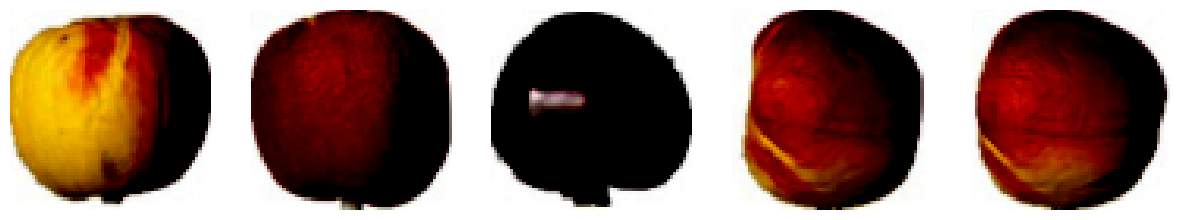

In [64]:
import matplotlib.pyplot as plt
fruit_dataset = FruitDataset(data_frame=combined_data, transform=transform)
dataloader = DataLoader(fruit_dataset, batch_size=64, shuffle=True,)


#     break

fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for idx in range(5):
    img = images[idx]
    img = img.permute(1, 2, 0).cpu().numpy()
    axs[idx].imshow(img)
    axs[idx].axis('off')

plt.show()

In [66]:
for images, labels in dataloader:
    print("Batch shape:", images.shape)  
    print("Label shape:", labels.shape)
    break


Batch shape: torch.Size([64, 3, 64, 64])
Label shape: torch.Size([64])


In [117]:
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 150
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 300

In [87]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
    
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
    
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
    
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
    
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
    
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
    
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        return img

   

In [88]:
from torchinfo import summary

model = Generator(100)

summary(model, input_size=(1, 100))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 64, 64]            --
├─Sequential: 1-1                        [1, 3, 64, 64]            --
│    └─Linear: 2-1                       [1, 8192]                 827,392
│    └─ReLU: 2-2                         [1, 8192]                 --
│    └─Unflatten: 2-3                    [1, 128, 8, 8]            --
│    └─Upsample: 2-4                     [1, 128, 16, 16]          --
│    └─Conv2d: 2-5                       [1, 128, 16, 16]          147,584
│    └─BatchNorm2d: 2-6                  [1, 128, 16, 16]          256
│    └─ReLU: 2-7                         [1, 128, 16, 16]          --
│    └─Upsample: 2-8                     [1, 128, 32, 32]          --
│    └─Conv2d: 2-9                       [1, 64, 32, 32]           73,792
│    └─BatchNorm2d: 2-10                 [1, 64, 32, 32]           128
│    └─ReLU: 2-11                        [1, 64, 32, 32]           --

In [105]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ZeroPad2d((0, 1, 0, 1)),
            nn.BatchNorm2d(64, momentum=0.82),
            nn.LeakyReLU(0.25),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.82),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256, momentum=0.8),
            nn.LeakyReLU(0.25),
            nn.Dropout(0.25),

            nn.Flatten(),
            nn.Linear(256 * 5 * 5 ,1),

        )
    def forward(self, img):
        validity = self.model(img)
        return validity
    

In [106]:
from torchinfo import summary

model = Discriminator()

summary(model, input_size=(1,3,64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           896
│    └─LeakyReLU: 2-2                    [1, 32, 32, 32]           --
│    └─Dropout: 2-3                      [1, 32, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 64, 16, 16]           18,496
│    └─ZeroPad2d: 2-5                    [1, 64, 17, 17]           --
│    └─BatchNorm2d: 2-6                  [1, 64, 17, 17]           128
│    └─LeakyReLU: 2-7                    [1, 64, 17, 17]           --
│    └─Dropout: 2-8                      [1, 64, 17, 17]           --
│    └─Conv2d: 2-9                       [1, 128, 9, 9]            73,856
│    └─BatchNorm2d: 2-10                 [1, 128, 9, 9]            256
│    └─LeakyReLU: 2-11                   [1, 128, 9, 9]            --
│   

In [115]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

adversarial_loss = nn.BCEWithLogitsLoss()

optimizer_G = optim.Adam(generator.parameters(),lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(beta1, beta2))

Epoch [1/300] Batch 20/23 Discriminator Loss: 0.4058 Generator Loss: 1.6269
Epoch [2/300] Batch 20/23 Discriminator Loss: 0.3543 Generator Loss: 1.9125
Epoch [3/300] Batch 20/23 Discriminator Loss: 0.3487 Generator Loss: 1.6401
Epoch [4/300] Batch 20/23 Discriminator Loss: 0.4465 Generator Loss: 1.6553
Epoch [5/300] Batch 20/23 Discriminator Loss: 0.2543 Generator Loss: 1.9946
Epoch [6/300] Batch 20/23 Discriminator Loss: 0.1929 Generator Loss: 2.4545
Epoch [7/300] Batch 20/23 Discriminator Loss: 0.3029 Generator Loss: 1.8875
Epoch [8/300] Batch 20/23 Discriminator Loss: 0.3572 Generator Loss: 1.8764
Epoch [9/300] Batch 20/23 Discriminator Loss: 0.4062 Generator Loss: 2.1227
Epoch [10/300] Batch 20/23 Discriminator Loss: 0.3365 Generator Loss: 1.8525
Epoch [11/300] Batch 20/23 Discriminator Loss: 0.3274 Generator Loss: 2.4277
Epoch [12/300] Batch 20/23 Discriminator Loss: 0.2593 Generator Loss: 2.4060
Epoch [13/300] Batch 20/23 Discriminator Loss: 0.3064 Generator Loss: 1.6322
Epoch [1

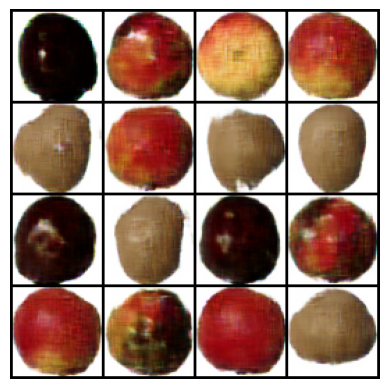

Epoch [51/300] Batch 20/23 Discriminator Loss: 0.2423 Generator Loss: 2.2058
Epoch [52/300] Batch 20/23 Discriminator Loss: 0.1947 Generator Loss: 2.4504
Epoch [53/300] Batch 20/23 Discriminator Loss: 0.3769 Generator Loss: 1.8908
Epoch [54/300] Batch 20/23 Discriminator Loss: 0.2243 Generator Loss: 2.4489
Epoch [55/300] Batch 20/23 Discriminator Loss: 0.2352 Generator Loss: 2.9252
Epoch [56/300] Batch 20/23 Discriminator Loss: 0.2639 Generator Loss: 2.5179
Epoch [57/300] Batch 20/23 Discriminator Loss: 0.2247 Generator Loss: 2.2500
Epoch [58/300] Batch 20/23 Discriminator Loss: 0.2144 Generator Loss: 2.1746
Epoch [59/300] Batch 20/23 Discriminator Loss: 0.2630 Generator Loss: 2.4275
Epoch [60/300] Batch 20/23 Discriminator Loss: 0.3650 Generator Loss: 2.4207
Epoch [61/300] Batch 20/23 Discriminator Loss: 0.1667 Generator Loss: 2.7845
Epoch [62/300] Batch 20/23 Discriminator Loss: 0.3255 Generator Loss: 2.4917
Epoch [63/300] Batch 20/23 Discriminator Loss: 0.2175 Generator Loss: 3.0510

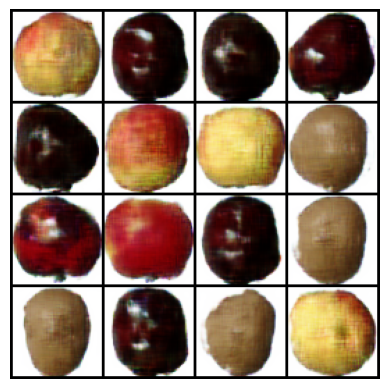

Epoch [101/300] Batch 20/23 Discriminator Loss: 0.2864 Generator Loss: 2.6586
Epoch [102/300] Batch 20/23 Discriminator Loss: 0.2383 Generator Loss: 2.8666
Epoch [103/300] Batch 20/23 Discriminator Loss: 0.2209 Generator Loss: 2.8715
Epoch [104/300] Batch 20/23 Discriminator Loss: 0.2226 Generator Loss: 2.8758
Epoch [105/300] Batch 20/23 Discriminator Loss: 0.2015 Generator Loss: 2.6840
Epoch [106/300] Batch 20/23 Discriminator Loss: 0.2327 Generator Loss: 2.2283
Epoch [107/300] Batch 20/23 Discriminator Loss: 0.2612 Generator Loss: 2.4241
Epoch [108/300] Batch 20/23 Discriminator Loss: 0.1688 Generator Loss: 3.4942
Epoch [109/300] Batch 20/23 Discriminator Loss: 0.1692 Generator Loss: 2.7033
Epoch [110/300] Batch 20/23 Discriminator Loss: 0.2174 Generator Loss: 3.0759
Epoch [111/300] Batch 20/23 Discriminator Loss: 0.1677 Generator Loss: 3.0518
Epoch [112/300] Batch 20/23 Discriminator Loss: 0.1921 Generator Loss: 3.2363
Epoch [113/300] Batch 20/23 Discriminator Loss: 0.2205 Generator

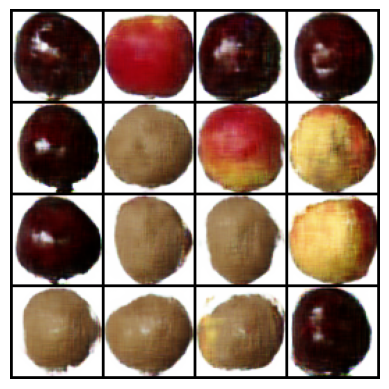

Epoch [151/300] Batch 20/23 Discriminator Loss: 0.1717 Generator Loss: 3.3566
Epoch [152/300] Batch 20/23 Discriminator Loss: 0.1547 Generator Loss: 4.4415
Epoch [153/300] Batch 20/23 Discriminator Loss: 0.1970 Generator Loss: 2.7968
Epoch [154/300] Batch 20/23 Discriminator Loss: 0.2678 Generator Loss: 2.9858
Epoch [155/300] Batch 20/23 Discriminator Loss: 0.1651 Generator Loss: 3.0625
Epoch [156/300] Batch 20/23 Discriminator Loss: 0.1274 Generator Loss: 2.9910
Epoch [157/300] Batch 20/23 Discriminator Loss: 0.2735 Generator Loss: 2.9383
Epoch [158/300] Batch 20/23 Discriminator Loss: 0.1880 Generator Loss: 2.7768
Epoch [159/300] Batch 20/23 Discriminator Loss: 0.2603 Generator Loss: 2.7661
Epoch [160/300] Batch 20/23 Discriminator Loss: 0.2346 Generator Loss: 2.6548
Epoch [161/300] Batch 20/23 Discriminator Loss: 0.2039 Generator Loss: 4.1341
Epoch [162/300] Batch 20/23 Discriminator Loss: 0.1217 Generator Loss: 3.7811
Epoch [163/300] Batch 20/23 Discriminator Loss: 0.1101 Generator

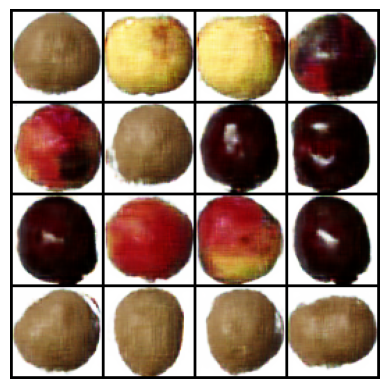

Epoch [201/300] Batch 20/23 Discriminator Loss: 0.2207 Generator Loss: 2.8916
Epoch [202/300] Batch 20/23 Discriminator Loss: 0.1768 Generator Loss: 3.6718
Epoch [203/300] Batch 20/23 Discriminator Loss: 0.1658 Generator Loss: 3.8450
Epoch [204/300] Batch 20/23 Discriminator Loss: 0.1513 Generator Loss: 3.6627
Epoch [205/300] Batch 20/23 Discriminator Loss: 0.0989 Generator Loss: 3.9439
Epoch [206/300] Batch 20/23 Discriminator Loss: 0.2437 Generator Loss: 3.5607
Epoch [207/300] Batch 20/23 Discriminator Loss: 0.1545 Generator Loss: 3.7422
Epoch [208/300] Batch 20/23 Discriminator Loss: 0.2334 Generator Loss: 3.8171
Epoch [209/300] Batch 20/23 Discriminator Loss: 0.1215 Generator Loss: 3.9780
Epoch [210/300] Batch 20/23 Discriminator Loss: 0.1184 Generator Loss: 2.8899
Epoch [211/300] Batch 20/23 Discriminator Loss: 0.1883 Generator Loss: 2.6380
Epoch [212/300] Batch 20/23 Discriminator Loss: 0.1527 Generator Loss: 5.5108
Epoch [213/300] Batch 20/23 Discriminator Loss: 0.1283 Generator

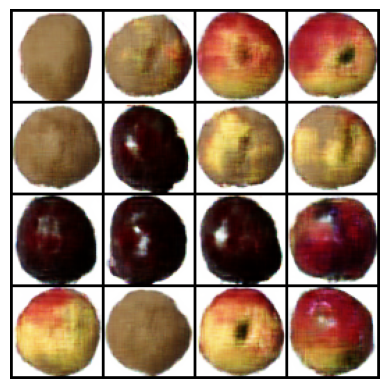

Epoch [251/300] Batch 20/23 Discriminator Loss: 0.1605 Generator Loss: 3.0264
Epoch [252/300] Batch 20/23 Discriminator Loss: 0.1203 Generator Loss: 4.1796
Epoch [253/300] Batch 20/23 Discriminator Loss: 0.1719 Generator Loss: 3.7561
Epoch [254/300] Batch 20/23 Discriminator Loss: 0.1090 Generator Loss: 3.8285
Epoch [255/300] Batch 20/23 Discriminator Loss: 0.0872 Generator Loss: 4.7183
Epoch [256/300] Batch 20/23 Discriminator Loss: 0.1438 Generator Loss: 3.4092
Epoch [257/300] Batch 20/23 Discriminator Loss: 0.1163 Generator Loss: 3.6827
Epoch [258/300] Batch 20/23 Discriminator Loss: 0.1262 Generator Loss: 4.0304
Epoch [259/300] Batch 20/23 Discriminator Loss: 0.1497 Generator Loss: 3.7249
Epoch [260/300] Batch 20/23 Discriminator Loss: 0.1193 Generator Loss: 4.4215
Epoch [261/300] Batch 20/23 Discriminator Loss: 0.2079 Generator Loss: 3.9306
Epoch [262/300] Batch 20/23 Discriminator Loss: 0.1341 Generator Loss: 3.6406
Epoch [263/300] Batch 20/23 Discriminator Loss: 0.1041 Generator

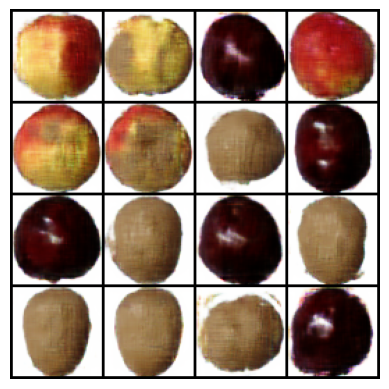

In [119]:
for epoch in range(epochs):
    generator.train(); discriminator.train()

    for i, batch in enumerate(dataloader):
        real_images = batch[0].to(device)
        N = real_images.size(0)

        # Targets
        valid = torch.ones(N, 1, device=device)
        fake  = torch.zeros(N, 1, device=device)

        # ---- D step ----
        optimizer_D.zero_grad()
        z = torch.randn(N, latent_dim, device=device)
        fake_images = generator(z)

        real_loss = adversarial_loss(discriminator(real_images), valid)
        fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)
        d_loss.backward()
        optimizer_D.step()

        # ---- G step ----
        optimizer_G.zero_grad()
        # optional: z = torch.randn(N, latent_dim, device=device)
        gen_images = generator(z)
        g_loss = adversarial_loss(discriminator(gen_images), valid)
        g_loss.backward()
        optimizer_G.step()

        if (i + 1) % 20 == 0:
            print(
                f"Epoch [{epoch+1}/{epochs}] Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}"
            )

    if (epoch + 1) % 50 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).cpu()
            grid = torchvision.utils.make_grid(generated, nrow=4, normalize=True)
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis("off")
            plt.show()
